In [1]:
import json
import pandas as pd
import os

df = pd.DataFrame()
for dirname, _, filenames in os.walk('../data/100/'):
    for filename in filenames:
        data = {}
        with open(os.path.join(dirname, filename),'r') as file:
            d = json.loads(file.read())
        data['date'] = d['Indices']['NDVI']['Serie Processada']['Data']
        data['indices'] = d['Indices']['NDVI']['Serie Processada']['Indice']
        part = pd.DataFrame(data)
        part['date'] = pd.to_datetime(part['date'], format='%Y-%m-%d')
        print(os.path.join(dirname, filename))
        df = pd.concat([df, part])
df.head(10)

../data/100/2014-2015.json
../data/100/2016-2017.json
../data/100/2018-2019.json
../data/100/2015-2016.json
../data/100/2017-2018.json


,date,indices
0,2014-07-04,0.565087
1,2014-07-12,0.577556
2,2014-07-20,0.570085
3,2014-07-28,0.525197
4,2014-08-05,0.479784
5,2014-08-13,0.462151
6,2014-08-21,0.474681
7,2014-08-29,0.500842
8,2014-09-06,0.520316
9,2014-09-14,0.521451


In [2]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.groupby(df.index).mean()
df = df.asfreq("W",method='backfill')
df = df.sort_index()
df.head(10)

,indices
date,
2014-07-06,0.577556
2014-07-13,0.570085
2014-07-20,0.570085
2014-07-27,0.525197
2014-08-03,0.479784
2014-08-10,0.462151
2014-08-17,0.474681
2014-08-24,0.500842
2014-08-31,0.520316


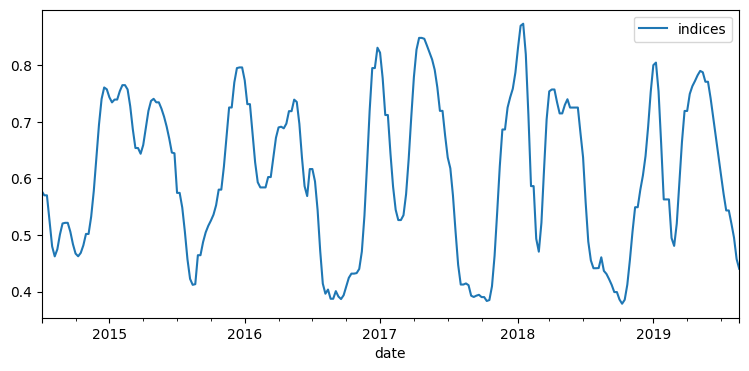

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 4))
df['indices'].plot(ax=ax, label='indices')
ax.legend()

In [4]:
from datetime import datetime

steps=10
X_train = df.loc[:datetime.strptime('2019-02-28', "%Y-%m-%d")]
X_test = df.loc[datetime.strptime('2019-02-28', "%Y-%m-%d"):datetime.strptime('2019-04-30', "%Y-%m-%d")]

In [5]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
auto = auto_arima(
    X_train['indices'],
    seasonal=True,
    stationary=True,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1092.883, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-273.115, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-914.192, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-563.068, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=458.588, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1065.369, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1094.363, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1023.326, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1096.157, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1094.382, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1092.689, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1070.659, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.498 seconds


In [6]:
sarima = SARIMAX(X_train['indices'],order=auto.order,seasonal_order=(5,1,4,8),freq='W',enforce_stationarity=True)
model = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94569D+00    |proj g|=  7.22229D+00


 This problem is unconstrained.



At iterate    5    f= -1.96726D+00    |proj g|=  2.03794D+00

At iterate   10    f= -1.98971D+00    |proj g|=  3.28801D-01

At iterate   15    f= -2.00588D+00    |proj g|=  3.29463D+00

At iterate   20    f= -2.11576D+00    |proj g|=  3.97812D-01

At iterate   25    f= -2.12523D+00    |proj g|=  2.27686D-01

At iterate   30    f= -2.13927D+00    |proj g|=  9.17053D-01

At iterate   35    f= -2.14061D+00    |proj g|=  1.04051D+00

At iterate   40    f= -2.14919D+00    |proj g|=  1.05945D+00

At iterate   45    f= -2.15144D+00    |proj g|=  9.54498D-01

At iterate   50    f= -2.15222D+00    |proj g|=  1.82789D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/pedro/workspace/POP-backend/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
forecast = model.get_forecast(steps=len(X_test))
print(type(forecast))
forecast = pd.DataFrame(forecast.predicted_mean)
forecast.head(10)

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


,predicted_mean
2019-03-03,0.449000
2019-03-10,0.419752
2019-03-17,0.427011
2019-03-24,0.432608
2019-03-31,0.455936
2019-04-07,0.492773
2019-04-14,0.531933
2019-04-21,0.552969
2019-04-28,0.557997


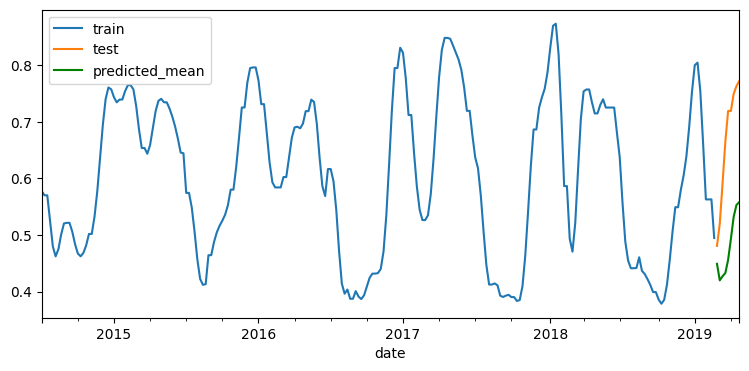

In [8]:
fig, ax=plt.subplots(figsize=(9, 4))
X_train['indices'].plot(ax=ax, label='train')
X_test['indices'].plot(ax=ax, label='test')
forecast.plot(ax=ax, label='predictions', color='green')
ax.legend()

In [9]:
import joblib

joblib.dump(model,'../model/100.h5')

['../model/100.h5']

In [101]:
from cassandra.cluster import Cluster
import uuid

cluster = Cluster(['localhost'])
session = cluster.connect('prediction')
for i in df.iterrows():
    query = "INSERT INTO data_series (data_id, id_municipio, valor_indice, data) VALUES (%s,%s, %s, %s)"
    session.execute(query, (uuid.uuid4(), 100, i[1]['indices'], f'{i[0].strftime("%Y-%m-%d")}'))
session.shutdown()
cluster.shutdown()